In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 

df = pd.read_parquet('data/df_groupby_ip.parquet.gzip')
df.head(5)

,ip,count,size,request_lenght,spambot
0,1.38.188.99,1,712495,112,0
1,1.47.151.27,2,1630020,32,0
2,1.85.11.244,1,497562,32,0
3,100.24.12.213,2,13623,32,0
4,101.108.5.245,1,7725352,32,0


In [2]:
df_groupby_ip = df
df_robust_scaler = preprocessing.RobustScaler().fit_transform(df_groupby_ip[["count", "size", "spambot", "request_lenght"]])
df_robust_scaler = pd.DataFrame(df_robust_scaler, columns=["count", "size", "spambot", "request_lenght"])
df_robust_scaler

,count,size,spambot,request_lenght
0,-0.5,0.189874,0.0,0.134615
1,0.0,0.646839,0.0,-0.634615
2,-0.5,0.082829,0.0,-0.634615
3,0.0,-0.158192,0.0,-0.634615
4,-0.5,3.682559,0.0,-0.634615
...,...,...,...,...
8823,0.0,0.424730,0.0,0.000000
8824,0.0,-0.053067,0.0,-0.096154
8825,0.0,-0.157715,0.0,-0.634615
8826,2.0,-0.138564,0.0,-0.625000


### KMedias

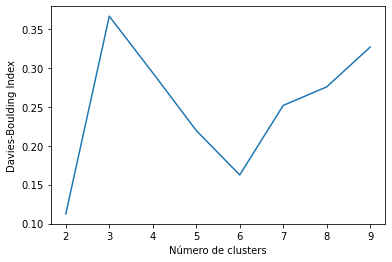

In [3]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

# Creo un diccionario con el indice de David Bouldin 
db_indexes = {}
for n in range(2,10):
    kmeans = KMeans(n).fit(df_robust_scaler.values)
    db_index = davies_bouldin_score(df_robust_scaler.values, kmeans.labels_)
    db_indexes.update({n: db_index})

# Grafico
plt.plot(list(db_indexes.keys()), list(db_indexes.values()))
plt.xlabel("Número de clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

Probamos con un N = 2 para KMeans

In [4]:
n_clusters = 2
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df_groupby_ip["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_

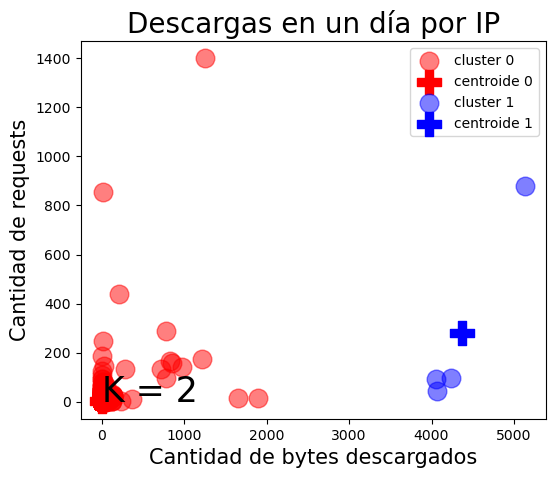

In [5]:
# Grafico 

plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_robust_scaler[df_robust_scaler["cluster"] == cluster]["count"],
                df_robust_scaler[df_robust_scaler["cluster"] == cluster]["size"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.show()

A continuación se utilizará la técnica de [Arbol de clasificación](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) para explicar que criterios se usaron para el clustering

In [6]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot", "request_lenght"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)


1.0
|--- accesos <= 5492.50
|   |--- class: 0
|--- accesos >  5492.50
|   |--- class: 1



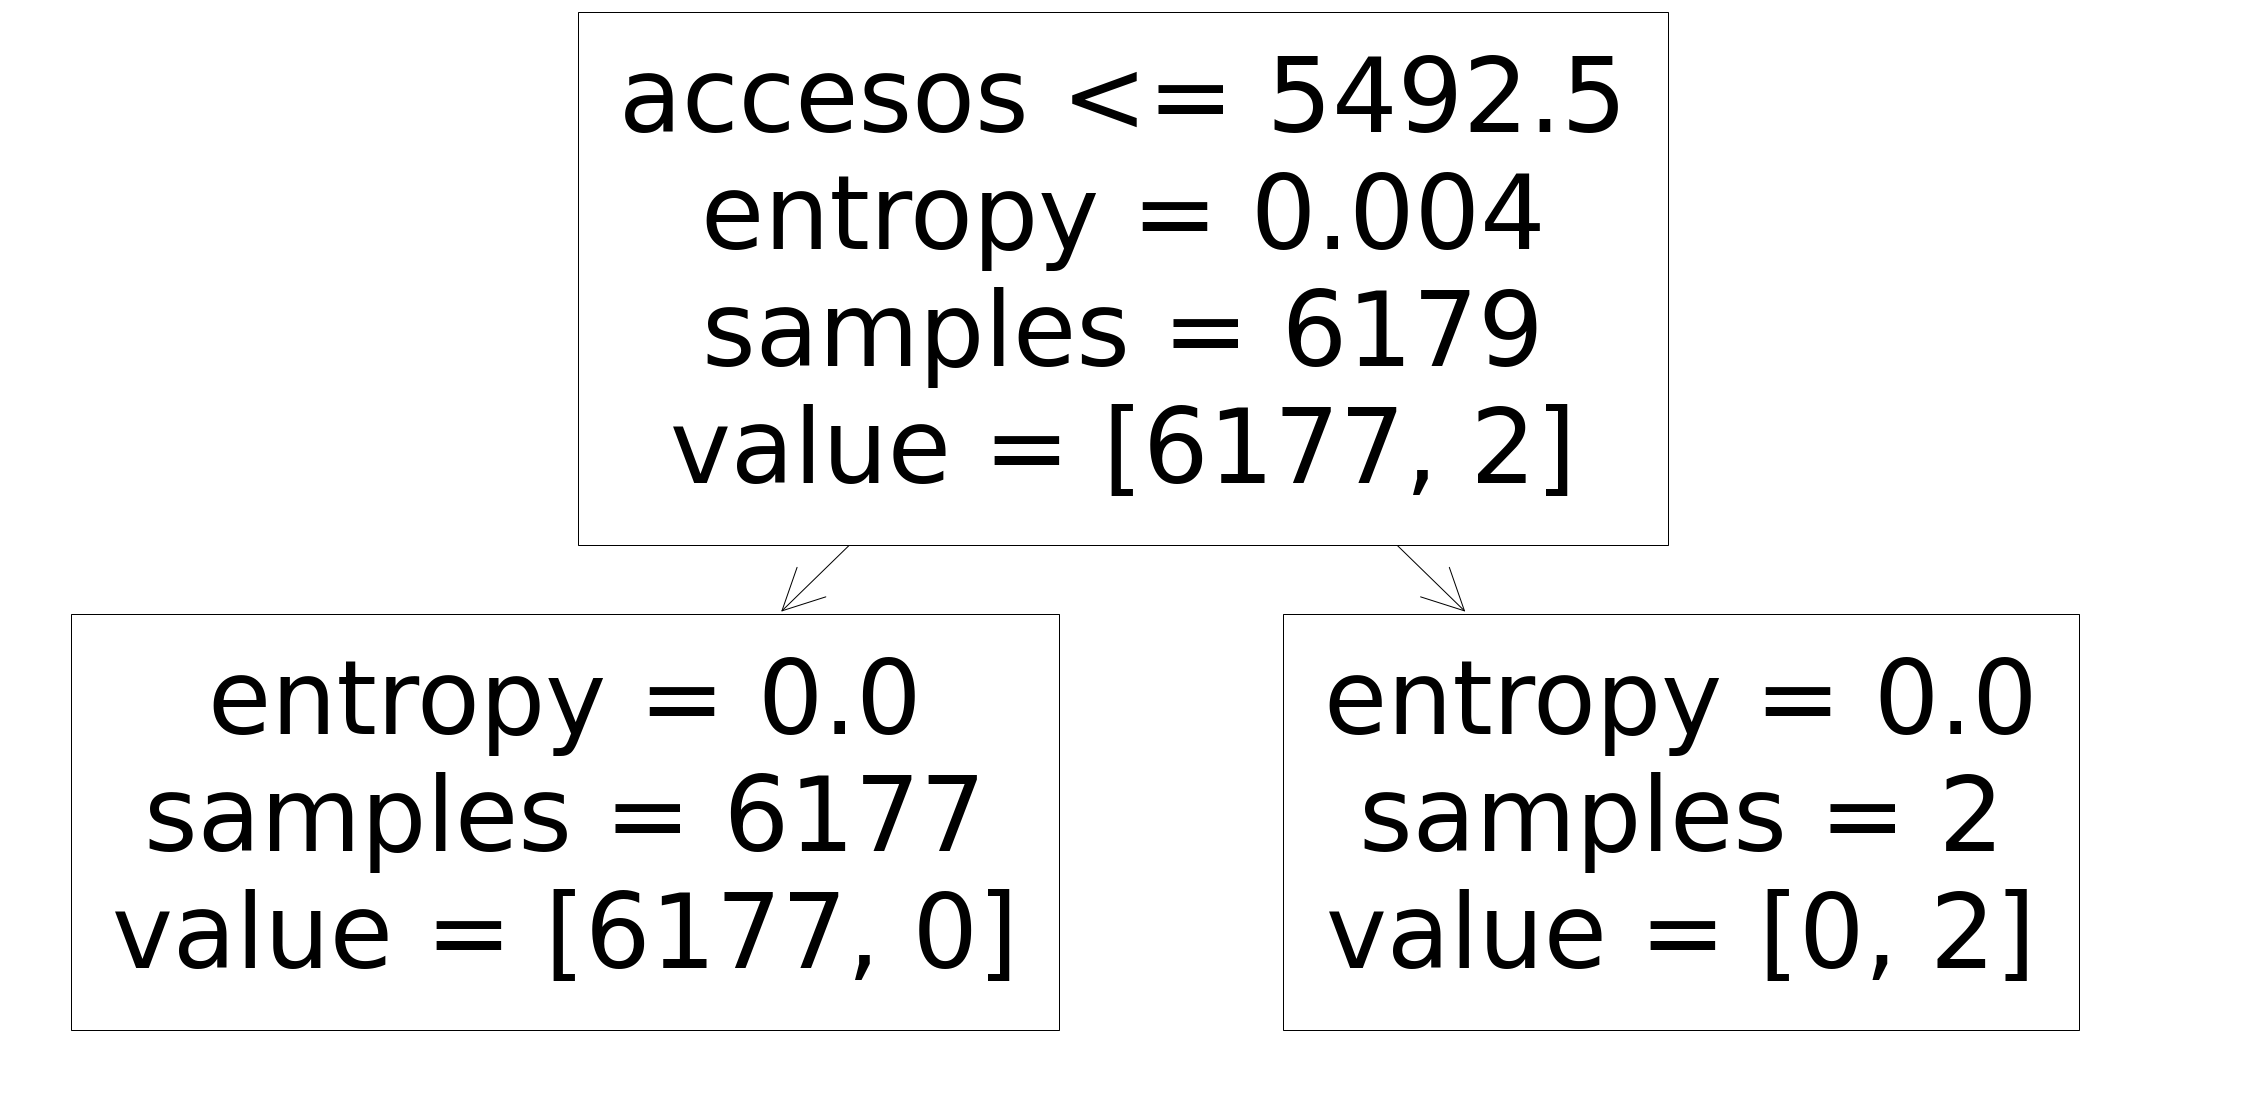

In [7]:
from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["accesos", "bytes", "bot", 'longitud de request']))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["accesos", "bytes", "bot", "longitud de request"])
plt.show()



### KMedias con 6

In [8]:
n_clusters = 6
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df_groupby_ip["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_

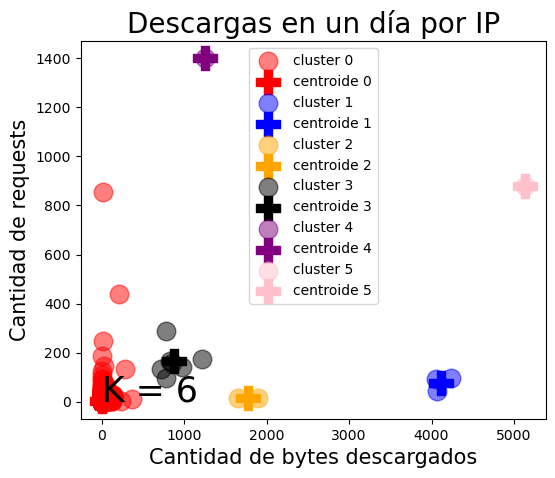

In [9]:
n_clusters = 6
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df_robust_scaler["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_

plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_robust_scaler[df_robust_scaler["cluster"] == cluster]["count"],
                df_robust_scaler[df_robust_scaler["cluster"] == cluster]["size"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.show()

Árbol para explicar kmedias con 6 clusters

1.0
|--- accesos <= 1152.00
|   |--- class: 0
|--- accesos >  1152.00
|   |--- accesos <= 2462.50
|   |   |--- class: 2
|   |--- accesos >  2462.50
|   |   |--- accesos <= 5714.00
|   |   |   |--- bytes <= 1418932660.00
|   |   |   |   |--- class: 4
|   |   |   |--- bytes >  1418932660.00
|   |   |   |   |--- class: 5
|   |   |--- accesos >  5714.00
|   |   |   |--- accesos <= 9194.00
|   |   |   |   |--- class: 1
|   |   |   |--- accesos >  9194.00
|   |   |   |   |--- class: 3



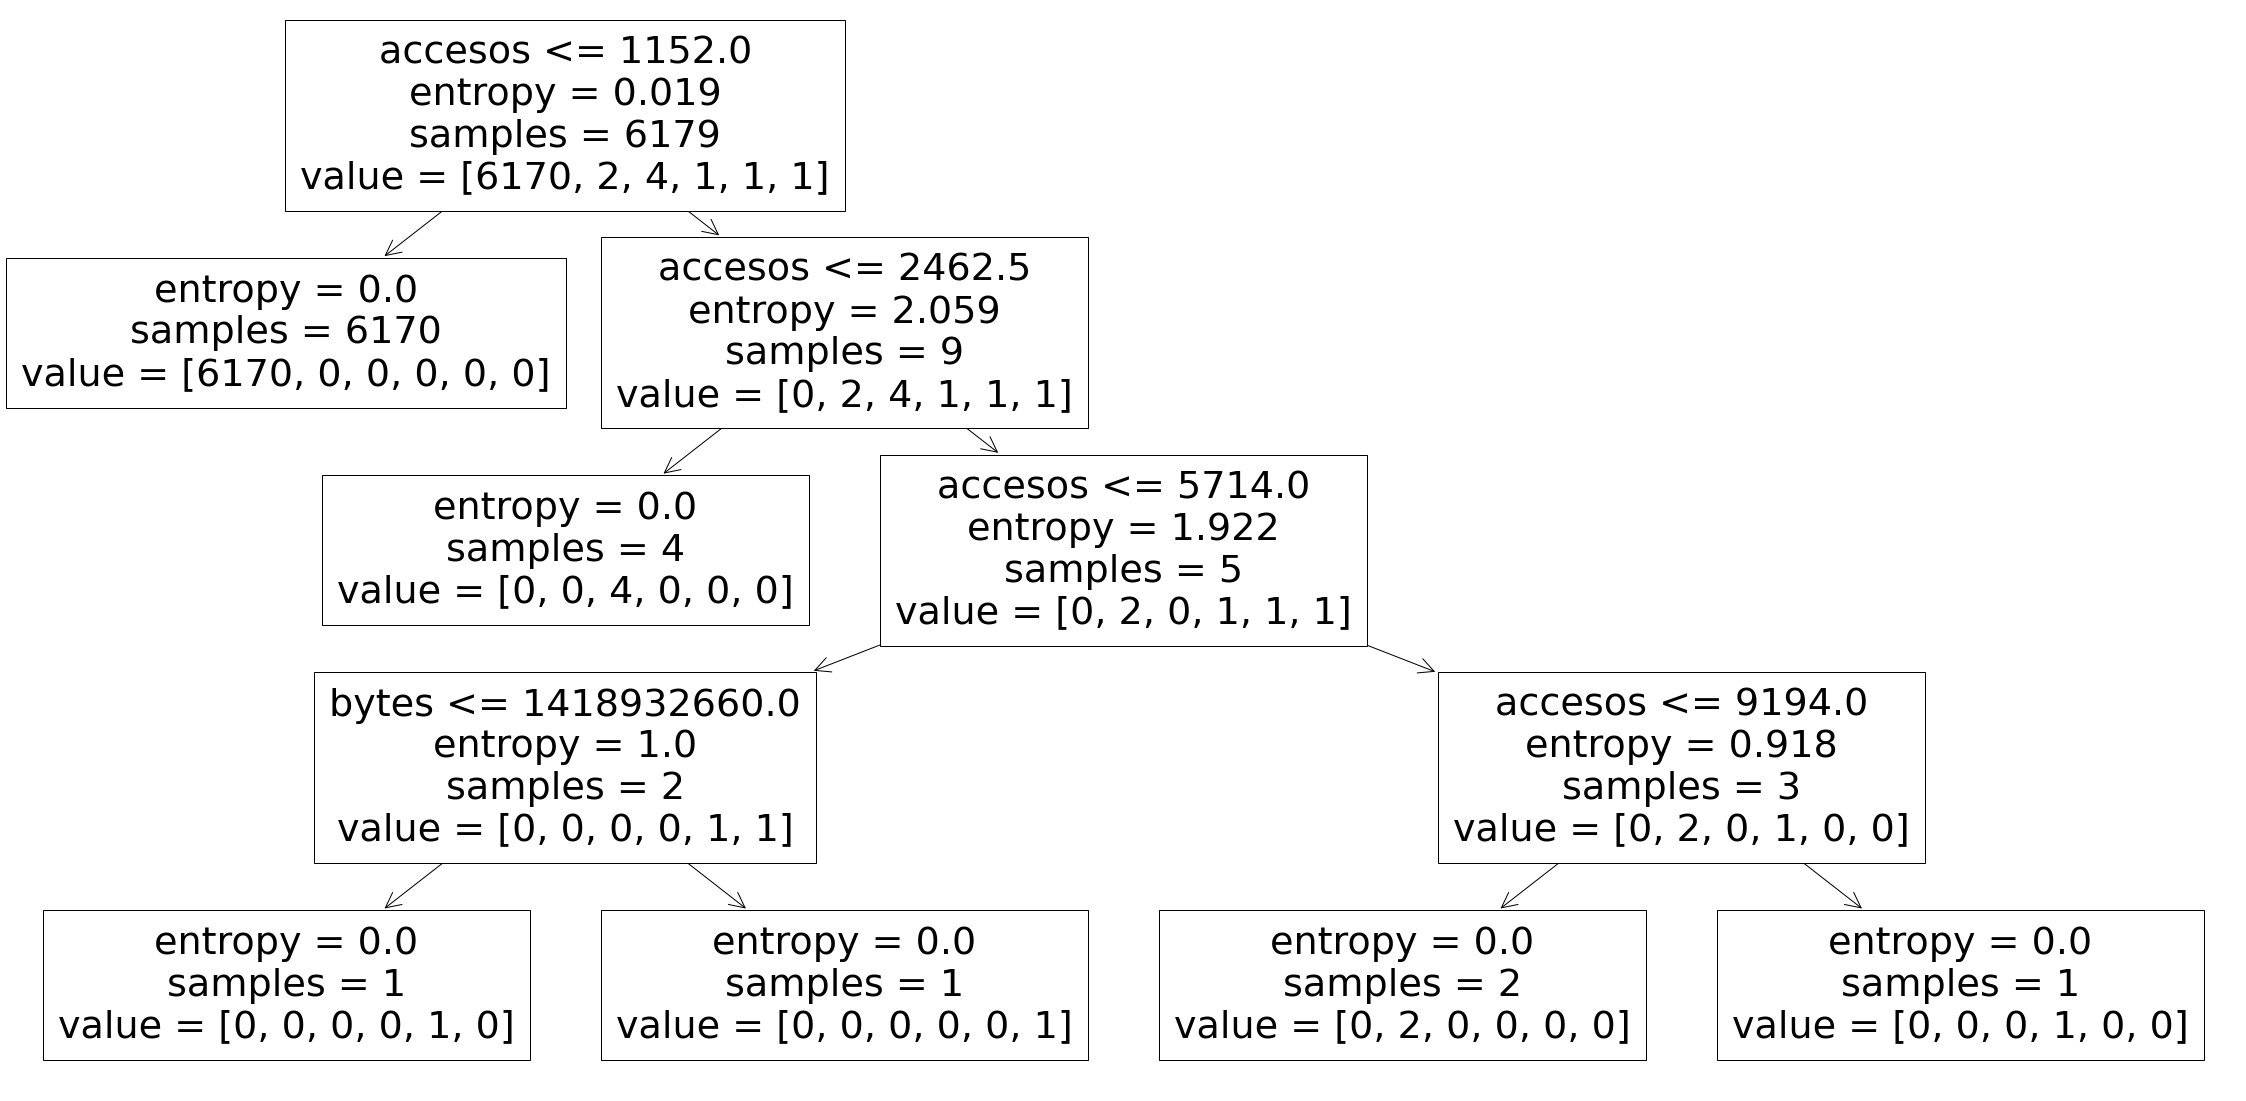

In [10]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot", "request_lenght"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)

from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["accesos", "bytes", "bot", 'longitud de request']))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["accesos", "bytes", "bot", "longitud de request"])

plt.show()



In [11]:
df_groupby_ip[(df_groupby_ip["cluster"] != 1) & (df_groupby_ip["spambot"] == 0)]

,ip,count,size,request_lenght,spambot,cluster
0,1.38.188.99,1,712495,112,0,0
1,1.47.151.27,2,1630020,32,0,0
2,1.85.11.244,1,497562,32,0,0
3,100.24.12.213,2,13623,32,0,0
4,101.108.5.245,1,7725352,32,0,0
...,...,...,...,...,...,...
8823,98.126.219.75,2,1184056,98,0,0
8824,98.167.168.137,2,224700,88,0,0
8825,98.176.225.232,2,14582,32,0,0
8826,99.150.195.19,6,53034,33,0,0


In [12]:
for i in range(kmeans.n_clusters):
    print('Accesos en cluster {}: '.format(i) + str(len(df_groupby_ip[df_groupby_ip['cluster'] == i])))
    print('Bots declarados en cluster {}: '.format(i) + str(len(df_groupby_ip[(df_groupby_ip['cluster'] == i) & (df_groupby_ip['spambot'] == 1)])))

Accesos en cluster 0: 8814
Bots declarados en cluster 0: 880
Accesos en cluster 1: 3
Bots declarados en cluster 1: 3
Accesos en cluster 2: 7
Bots declarados en cluster 2: 7
Accesos en cluster 3: 1
Bots declarados en cluster 3: 1
Accesos en cluster 4: 2
Bots declarados en cluster 4: 1
Accesos en cluster 5: 1
Bots declarados en cluster 5: 1
